In [132]:
using Polynomials
using DSP
using Plots
using StatsBase
pyplot()

include("wiener_filter_scalar_fft.jl")
include("ARMA_Generator.jl")

include("../../Model_Reduction_Dev.jl")

vector_wiener_filter_fft

## ARMA(p,q) signal with additive white noise

Choose signal process

In [133]:
steps = 10^6
discard = 10^4

p = rand(1:9)
q = rand(1:9)

r = 1.0
Zeros_sig = 1 .- rand(q)*2
Poles_sig = 1 .- rand(p)*2

sig = ARMA_gen([1], r = r, 
    Zeros = Zeros_sig, 
    Poles = Poles_sig, 
    steps = steps, 
    discard = discard)

sig_test = ARMA_gen([1],r = r, 
    Zeros = Zeros_sig, 
    Poles = Poles_sig, 
    steps = steps, 
    discard = discard);
println(p,q)
println(Zeros_sig)
println(Poles_sig)

54
[-0.6939047116760495, 0.5971083881863999, 0.06440815196041072, 0.6871127497259049]
[0.33411147820381704, 0.539294525911016, 0.2489403294379846, -0.6817737058835203, 0.19018724379591978]


Here we produce the predictors now. They are a filtered and noisy observations of the signals.

In [134]:
σ = 1
w = [1, -5/4, 3/8]
pred = conv(w,sig)[length(w) : end] .+ σ*randn(steps);

pred_test = conv(w,sig_test)[discard + 1 : steps] .+ σ*randn(steps-discard);

In [135]:
h_num_fft = wiener_filter_fft(pred, sig,par = 150);

In [136]:
M_h = 1000

sig_vec = reshape(sig,1,:)
pred_vec = reshape(pred,1,:)

h_num_mat = vector_wiener_filter_fft(
    sig_vec,
    pred_vec,
    M_h;
    par = 2000,
    win = "Par",
    n = 3,
    p = 1500,
    PI = true,
    rtol = 1e-6
    )

h_num = real(reshape(h_num_mat,:));

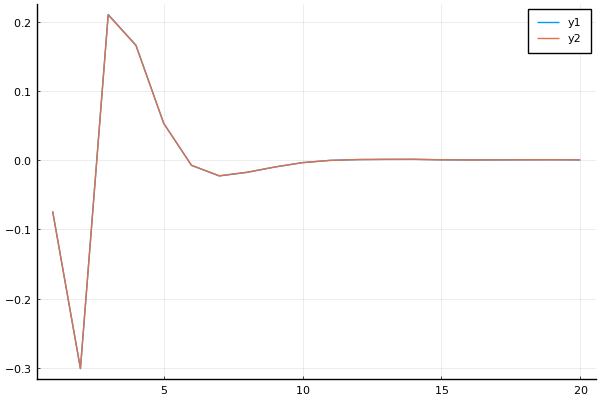

In [137]:
plot([real.(h_num[1:20]) real.(h_num_fft[1:20])] )

Now to verify the preformance.

In [138]:
sig_hat = conv(real.(h_num),pred)[1:steps];

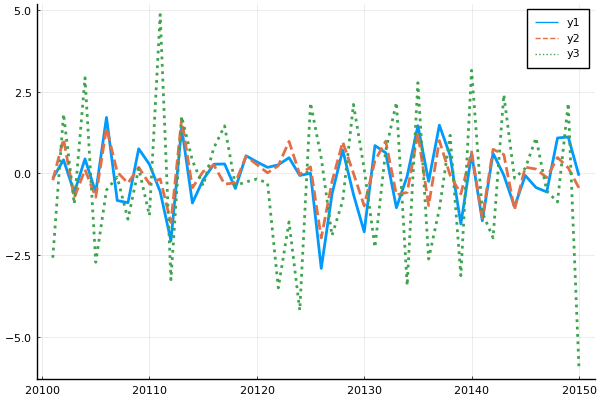

In [139]:
time = (1:50) .+ 20100
plot(time,[sig[time] sig_hat[time] pred[time]],
   line=(2,[:solid :dash :dot]))

In [140]:
error = sig .-sig_hat
lags = -100:10
C = crosscov(error,pred,lags);

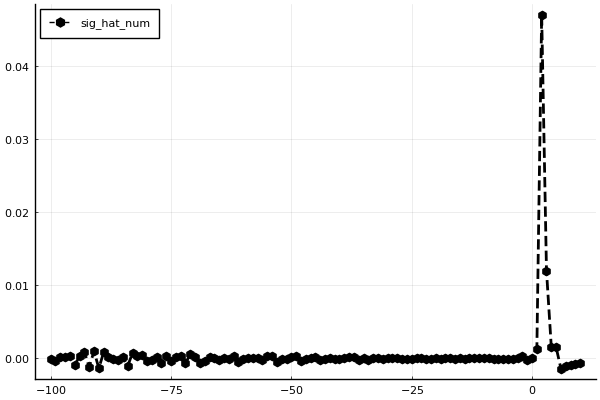

In [141]:
plot(lags, C,
    color=[:black :grey :red],
    line=(2,[:dash :dashdot :dot]),
    label=["sig_hat_num" "sig_hat_num_fft" "sig_hat_ana"],
    marker=([:hex :hex :d],6))